#Generalization is important as the data can be only a sample, it is incomplete and noisy.

**Overfitting** refers to a model that models the training data too well.

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

Overfitting is more likely with nonparametric and nonlinear models that have more flexibility when learning a target function. As such, many nonparametric machine learning algorithms also include parameters or techniques to limit and constrain how much detail the model learns.

For example, decision trees are a nonparametric machine learning algorithm that is very flexible and is subject to overfitting training data. This problem can be addressed by pruning a tree after it has learned in order to remove some of the detail it has picked up.

**Underfitting** refers to a model that can neither model the training data nor generalize to new data.

An underfit machine learning model is not a suitable model and will be obvious as it will have poor performance on the training data.

Underfitting is often not discussed as it is easy to detect given a good performance metric. The remedy is to move on and try alternate machine learning algorithms. Nevertheless, it does provide a good contrast to the problem of overfitting.

There are two important techniques that you can use when evaluating machine learning algorithms to limit overfitting:

    1.Use a resampling technique to estimate model accuracy.
    2.Hold back a validation dataset.

The most popular resampling technique is k-fold cross validation. It allows you to train and test your model k-times on different subsets of training data and build up an estimate of the performance of a machine learning model on unseen data.

A validation dataset is simply a subset of your training data that you hold back from your machine learning algorithms until the very end of your project. After you have selected and tuned your machine learning algorithms on your training dataset you can evaluate the learned models on the validation dataset to get a final objective idea of how the models might perform on unseen data.

Using cross validation is a gold standard in applied machine learning for estimating model accuracy on unseen data. If you have the data, using a validation dataset is also an excellent practice.

In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.5.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kp3p_wlf
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-kp3p_wlf
     |████████████████████████████████| 1.0MB 21.2MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01deadd830943879a6b90733ce3481e105b816620_-cp37-none-any.whl size=153744 sha256=ba946c4a2e9d449f9c7529d8381ab7ef3c4cbabf5c614648b19e67b0d10e912e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vib5wde4/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
#get data
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 87s 0us/step


In [6]:
FEATURES = 28
raw_ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")


In [7]:
type(raw_ds)

tensorflow.python.data.experimental.ops.readers.CsvDatasetV2

In [8]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [9]:
#TensorFlow is most efficient when operating on large batches of data.
#So instead of repacking each row individually make a new Dataset 
#that takes batches of 10000-examples, applies the pack_row function to each batch, 
#and then splits the batches back up into individual records:

packed_ds = raw_ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


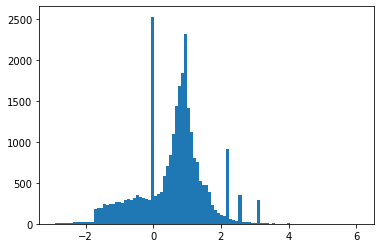

In [10]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

  #features are not normalized well.

In [11]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [12]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds


<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [14]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.



In [15]:
#training
"""
sets a schedules.InverseTimeDecay to hyperbolically decrease 
the learning rate to 1/2 of the base rate at 1000 epochs, 
1/3 at 2000 epochs and so on.
"""
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

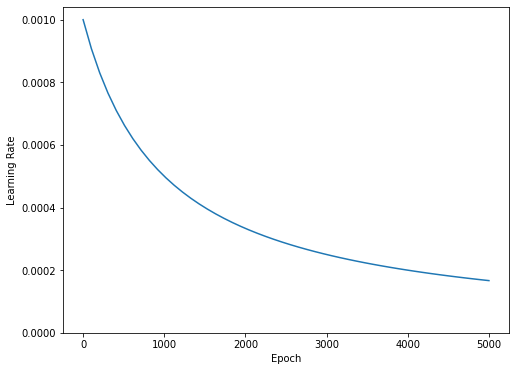

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [17]:
#callback
def get_callbacks(name):
  return [
          tfdocs.modeling.EpochDots(),
          tf.keras.callbacks.EarlyStopping(monitor="val_binary_crossentropy", patience=200),
          tf.keras.callbacks.TensorBoard(logdir/name)
  ]

In [18]:
#build model function
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"]
                )
  model.summary()

  training_history = model.fit(
      train_ds,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=validate_ds,
      callbacks=get_callbacks(name),
      verbose=0
  )

  return training_history
  

In [19]:
#train
simple_model = tf.keras.Sequential([
  tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
  tf.keras.layers.Dense(1)                                    
])

In [20]:
size_histories={}

In [ ]:
size_histories["simple"] = compile_and_fit(simple_model, "sizes/simple")


Epoch: 6400, accuracy:0.6887,  loss:0.5636,  val_accuracy:0.6540,  val_loss:0.5889,  


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-b17de06eee1e>", line 1, in <module>
    size_histories["simple"] = compile_and_fit(simple_model, "sizes/simple")
  File "<ipython-input-18-c8b7d5feef06>", line 17, in compile_and_fit
    verbose=0
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 1225, in fit
    _use_cached_eval_dataset=True)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 1483, in evaluate
    for _, iterator in data_handler.enumerate_epochs():  # Single epoch.
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 1199, in enumerate_epochs
    data_iterator = iter(self._dataset)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_o

KeyboardInterrupt: ignored